In [1]:
import numpy as np

def onedim_8sites_IsingModel_OBC(qc,n_qubits,dt):
    
    odd=[0,2,4,6]
    even=[1,3,5]
    for i in range(n_qubits):
        qc.rz(-2*ht*dt,i) #qc.rz(-2 * theta, i)  # Implements e^{i θ Z} to the qubit i
    qc.barrier()
    for i in odd:
        qc.cx(i,i+1)
    for i in odd:
        qc.rx(-2*J*dt,i)
    for i in odd:
        qc.cx(i,i+1)
    qc.barrier()
    for i in even:
        qc.cx(i,i+1)
    for i in even:
        qc.rx(-2*J*dt,i)
    for i in even:
        qc.cx(i,i+1)
    qc.barrier()      


In [2]:
from qiskit import QuantumCircuit, QuantumRegister 
from qiskit.quantum_info import Statevector


J=0.02
ht=1
dt=10
time_steps = [0,8,16,24,32,40,48]
n_qubits=8
qr=QuantumRegister(n_qubits)
qc=QuantumCircuit(qr)
target_qubit=4


In [ ]:
"""
Ibm_torino backend:
"""
# ===================================
# Run on a real quantum computer (here I store my account data locally)
# ===================================
from qiskit_ibm_runtime import QiskitRuntimeService

# Save data locally so you don't have to re-enter it every time
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="Dmohzowo29rkF2NMmBZzQVKRWrYPMveJ-TMZYqY4R7Ds",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/16dcfd66377b4cc8a83f675aeff3dbb4:df044669-10bd-4072-8fe1-fe3408cbd5f1::",
    overwrite=True
)

service = QiskitRuntimeService()

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
# Get a real backend
backend_real = service.backend("ibm_torino")  
sampler_real = Sampler(backend_real)



In [ ]:
# See which devices (simulators/QPUs) you have access to
backends = service.backends()
print(backends)

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]


In [ ]:
#ibm_torino backend implementation 
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile


shots = 10000
probs_noise = [] # Probability list of site 3 being in |1> (occupation value) as a function of Jt. That is: [occup.value(Jdt), occup.value(J2dt), ..., occup.value(Jdt*time_steps)]

for t in time_steps:   # empezamos en t=1
    counts_site4 = 0    
#  Create circuit from scratch and initialize
    qc_t = QuantumCircuit(n_qubits)
    qc_t.x(n_qubits - 1)
# Apply the evolution t times
    for _ in range(t):
        onedim_8sites_IsingModel_OBC(qc_t, n_qubits, dt)
    qc_t.measure_all()
# Measure target_qubit with measurement noise
    qc_transpiled = transpile(qc, backend=backend_real)
    job_real = sampler_real.run([qc_transpiled], shots=10000)
    counts_real = job_real.result()[0].data.meas.get_counts()
        
# Count how many times qubit 3 is in |1>
    for bitstring, freq in counts_real.items():
        if bitstring[-(target_qubit+1)] == "1":  # posición del qubit 3
            counts_site4 += freq
# Save empirical probability of obtaining “1”
    prob_site4_noise = counts_site4 / shots
    probs_noise.append(prob_site4_noise)



c:\Users\pablo\OneDrive\Escritorio\Universidad\TFG\Qiskit\Lib\site-packages\qiskit_ibm_runtime\utils\validations.py:41: UserWarning: The 0-th circuit has no output classical registers so the result will be empty. Did you mean to add measurement instructions?
  warnings.warn(


AttributeError: 'DataBin' object has no attribute 'meas'

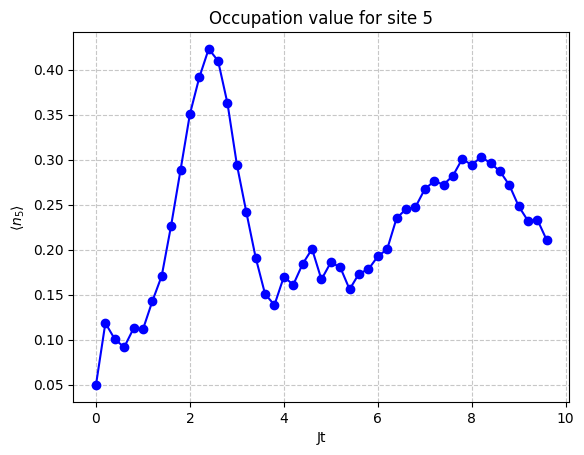

In [ ]:
import matplotlib.pyplot as plt

x_vals=np.arange(time_steps)*J*dt
plt.plot(x_vals, probs_noise, 'o', color='red')
plt.xlabel("Jt")
plt.ylabel(fr"$\langle n_{{{target_qubit}}} \rangle$")
plt.title(f"Occupation value for site {target_qubit}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()